# MIND 微软新闻数据集

 MIND
  ├── MINDlarge_dev
  │   ├── \_\_placeholder\_\_
  │   ├── behaviors.tsv
  │   ├── entity_embedding.vec
  │   ├── news.tsv
  │   └── relation_embedding.vec
  ├── MINDlarge_test
  ├── MINDlarge_train
  ├── MINDsmall_dev
  ├── MINDsmall_train


In [85]:
import pandas as pd
import numpy as np
import re
import ast
from ast import literal_eval

数据路径

In [2]:
data_path = "F:/DataSets/MIND/MINDsmall_train/"
behaviors_path = data_path + "behaviors.tsv"
entity_embeddings_path = data_path + "entity_embedding.vec"
news_path = data_path + "news.tsv"

* 印象 ID。展示的 ID。 int64
* 用户身份。用户的匿名 ID。str
* 时间。展示时间，格式为“MM/DD/YYYY HH:MM:SS AM/PM”。str
* 历史。该用户在本次曝光前的新闻点击历史记录（点击新闻的ID列表）。点击的新闻文章按时间排序。str
* 印象。本次展示中展示的新闻列表以及用户对其的点击行为（1为点击，0为未点击）。印象中的新闻顺序已被打乱。str

In [3]:
feature_names = ['impression_id', 'user_id', 'time', 'history', 'impressions']
behaviors_file = pd.read_table(behaviors_path, header=None, names=feature_names)
print(type(behaviors_file['impression_id'][0]),type(behaviors_file['user_id'][0]),type(behaviors_file['time'][0]),type(behaviors_file['history'][0]),type(behaviors_file['impressions'][0]))
behaviors_file.head(2)

<class 'numpy.int64'> <class 'str'> <class 'str'> <class 'str'> <class 'str'>


,impression_id,user_id,time,history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...


## 嵌入表示
读取实体嵌入向量，每个向量是一个100维的数组
问题：
1. 只有实体的嵌入，每个新闻有标题和摘要的若干实体，没有正文内容的实体
2. 暂用：mean(（标题+摘要）.嵌入) 代表 新闻嵌入


In [62]:
entity_embeddings_file = pd.read_csv(entity_embeddings_path, header=None, sep='\t')

# 将ID和向量分离，ID在第一列，向量在剩余的列
entity_ids = entity_embeddings_file.iloc[:, 0]
embedding_vectors = entity_embeddings_file.iloc[:, 1:-1]  # 修改这里，去除最后一个可能的空列

# 使用apply函数去除"Q"前缀并转换为整数
converted_entity_ids = entity_embeddings_file.iloc[:, 0].apply(lambda x: int(x[1:]))

# 将向量转换为一个numpy数组，这样每个向量就是一个数组形式
embedding_vectors = embedding_vectors.apply(lambda row: np.array(row), axis=1)

# 创建一个新的DataFrame来存储这些值
entity_embeddings = pd.DataFrame({'EID': entity_ids, 'Vector': embedding_vectors})

# 设置ID为索引，方便后续查询
# entity_embeddings.set_index('EID', inplace=True)
entity_embeddings.head(2)

,EID,Vector
0,Q41,"[-0.063388, -0.181451, 0.057501, -0.091254, -0..."
1,Q1860,"[0.060958, 0.069934, 0.015832, 0.079471, -0.02..."


## 构造用户兴趣表（行为表）
不是所有新闻都存在标题实体和摘要实体
步骤：
1. 构建新闻-嵌入表 √
2. 以user_id排序behavior_file
3. impressions到处交互新闻id
4. 通过新闻id，得到新闻嵌入
5. groupby用户id和不同时间段，计算平均嵌入，作为用户长中短期兴趣

In [91]:
import json
feature_names = ['news_id', 'label', 'sub_label', 'title', 'abstract', 'url', 'title_entity', 'abstract_entity']
news = pd.read_table(news_path, header=None, names=feature_names)

news['title_entity'].head()

0    [{"Label": "Prince Philip, Duke of Edinburgh",...
1    [{"Label": "Adipose tissue", "Type": "C", "Wik...
2                                                   []
3                                                   []
4    [{"Label": "Skin tag", "Type": "C", "WikidataI...
Name: title_entity, dtype: object

In [6]:
print(news['title_entity'][2])
print(type(news['title_entity'][2]))

[]
<class 'str'>


实体存储在title_entity和abstract_entity中，以json格式的字符串存在

In [92]:
df = news

# 定义一个函数来提取WikidataId和Confidence
def extract_wikidata_confidence(json_str):
    if type(json_str) == str:  # 检查字符串是否为空
        entities = json.loads(json_str)
        return [(entity["WikidataId"], entity["Confidence"]) for entity in entities]
    else:
        return []  # 返回一个空列表

# 应用这个函数到title_entity列
df['wikidata_confidence1'] = df['title_entity'].apply(extract_wikidata_confidence)
df['wikidata_confidence2'] = df['abstract_entity'].apply(extract_wikidata_confidence)

# print(df['wikidata_confidence1'])
# print(df['wikidata_confidence2'])

In [93]:
# 定义函数计算平均嵌入
def calculate_average_embedding(wikidata_confidence):
    embeddings = []
    for wikidata_id, _ in wikidata_confidence:
        embedding = entity_embeddings.loc[entity_embeddings['EID'] == wikidata_id, 'Vector'].values
        if embedding.size > 0:
            embeddings.append(embedding[0])
    
    if embeddings:
        # 计算找到的嵌入向量的平均值
        average_embedding = np.mean(embeddings, axis=0)
        return average_embedding
    else:
        return np.array([])  # 如果没有找到嵌入向量，返回空数组



In [94]:
df.head()

,news_id,label,sub_label,title,abstract,url,title_entity,abstract_entity,wikidata_confidence1,wikidata_confidence2
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],"[(Q80976, 1.0), (Q43274, 1.0), (Q9682, 0.97)]",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[(Q193583, 1.0)]","[(Q193583, 1.0)]"
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",[],"[(Q212, 0.946)]"
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",[],"[(Q155223, 1.0)]"
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[(Q3179593, 1.0)]","[(Q3179593, 1.0), (Q171171, 1.0), (Q371820, 0...."


In [95]:
# 检查 entity_embeddings 中 Vector 列的每一个向量的长度
lengths = entity_embeddings['Vector'].apply(lambda x: len(x))
print(lengths.unique())  # 这应该只返回一个唯一值：100

# 如果发现除了100以外的长度值，那么这可能是问题的来源


[100]


In [96]:
entity_embeddings['Vector'][0]

array([-0.063388, -0.181451,  0.057501, -0.091254, -0.076217, -0.052525,
        0.0505  , -0.224871, -0.018145,  0.030722,  0.064276,  0.073063,
        0.039489,  0.159404, -0.128784,  0.016325,  0.026797,  0.13709 ,
        0.001849, -0.059103,  0.012091,  0.045418,  0.000591,  0.211337,
       -0.034093, -0.074582,  0.014004, -0.099355,  0.170144,  0.109376,
       -0.014797,  0.071172,  0.080375,  0.045563, -0.046462,  0.070108,
        0.015413, -0.020874, -0.170324, -0.00113 ,  0.05981 ,  0.054342,
        0.027358, -0.028995, -0.224508,  0.066281, -0.200006,  0.018186,
        0.082396,  0.167178, -0.136239,  0.055134, -0.080195, -0.00146 ,
        0.031078, -0.017084, -0.091176, -0.036916,  0.124642, -0.098185,
       -0.054836,  0.152483, -0.053712,  0.092816, -0.112044, -0.072247,
       -0.114896, -0.036541, -0.186339, -0.16061 ,  0.037342, -0.133474,
        0.11008 ,  0.070678, -0.005586, -0.046667, -0.07201 ,  0.086424,
        0.026165,  0.030561,  0.077888, -0.117226, 

In [97]:
# # 应用函数到wikidata_confidence列
# df['average_embedding1'] = df['wikidata_confidence1'].apply(calculate_average_embedding)
# df['average_embedding2'] = df['wikidata_confidence2'].apply(calculate_average_embedding)
# 
# df.head()

,news_id,label,sub_label,title,abstract,url,title_entity,abstract_entity,wikidata_confidence1,wikidata_confidence2,average_embedding1,average_embedding2
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],"[(Q80976, 1.0), (Q43274, 1.0), (Q9682, 0.97)]",[],"[0.004057333333333334, -0.03991733333333333, -...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[(Q193583, 1.0)]","[(Q193583, 1.0)]","[-0.013597, -0.009758, 0.01712, -0.051993, 0.0...","[-0.013597, -0.009758, 0.01712, -0.051993, 0.0..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",[],"[(Q212, 0.946)]",[],"[-0.065324, -0.088163, -0.015203, -0.031949, 0..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",[],"[(Q155223, 1.0)]",[],"[0.003752, -0.061771, -0.037073, 0.02677, -0.0..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[(Q3179593, 1.0)]","[(Q3179593, 1.0), (Q171171, 1.0), (Q371820, 0....","[0.014257, 0.018351, 0.005199, 0.001773, 0.031...","[-0.008593666666666668, -0.0001680000000000003..."


验证一下

In [10]:
# # 80976 43284 9682
# print((entity_embeddings.loc[entity_embeddings["EID"]== "Q80976",'Vector'].values +
#       entity_embeddings.loc[entity_embeddings["EID"]== "Q43274",'Vector'].values +
#       entity_embeddings.loc[entity_embeddings["EID"]== "Q9682",'Vector'].values)/3)


In [111]:
# 检查 entity_embeddings 中 Vector 列的每一个向量的长度
lengths = df['average_embedding1'].apply(lambda x: len(x))
print(lengths.unique())  # 这应该只返回一个唯二值：100和0

[100   0]


In [112]:
# 定义函数计算两个向量的平均值
def average_vectors(row):
    v1 = row['average_embedding1']
    v2 = row['average_embedding2']
    
    # 检查是否有向量是0维的空值或None
    if isinstance(v1, np.ndarray) and v1.size > 0 and isinstance(v2, np.ndarray) and v2.size > 0:
        return (v1 + v2) / 2
    elif isinstance(v1, np.ndarray) and v1.size > 0:
        return v1
    elif isinstance(v2, np.ndarray) and v2.size > 0:
        return v2
    else:
         return np.array([], dtype=float)


In [113]:
# # 计算两个嵌入的平均嵌入
# df['average_embedding'] = df.apply(average_vectors, axis=1)
# df.head()

,news_id,label,sub_label,title,abstract,url,title_entity,abstract_entity,wikidata_confidence1,wikidata_confidence2,average_embedding1,average_embedding2,average_embedding
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],"[(Q80976, 1.0), (Q43274, 1.0), (Q9682, 0.97)]",[],"[0.004057333333333334, -0.03991733333333333, -...",[],"[0.004057333333333334, -0.03991733333333333, -..."
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[(Q193583, 1.0)]","[(Q193583, 1.0)]","[-0.013597, -0.009758, 0.01712, -0.051993, 0.0...","[-0.013597, -0.009758, 0.01712, -0.051993, 0.0...","[-0.013597, -0.009758, 0.01712, -0.051993, 0.0..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",[],"[(Q212, 0.946)]",[],"[-0.065324, -0.088163, -0.015203, -0.031949, 0...","[-0.065324, -0.088163, -0.015203, -0.031949, 0..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",[],"[(Q155223, 1.0)]",[],"[0.003752, -0.061771, -0.037073, 0.02677, -0.0...","[0.003752, -0.061771, -0.037073, 0.02677, -0.0..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[(Q3179593, 1.0)]","[(Q3179593, 1.0), (Q171171, 1.0), (Q371820, 0....","[0.014257, 0.018351, 0.005199, 0.001773, 0.031...","[-0.008593666666666668, -0.0001680000000000003...","[0.0028316666666666664, 0.009091499999999999, ..."


In [114]:
# print(type(df['average_embedding'][0]))
# print(len(df['average_embedding'][0]))
# lengths = df['average_embedding'].apply(lambda x: len(x))
# print(lengths.unique())  # 这应该只返回一个唯二值：100和0

<class 'numpy.ndarray'>
100
[100   0]


保存csv文件

In [115]:
# df.to_csv("news_embedding.csv")

读取csv文件

表1： 新闻-嵌入表

In [131]:
# 读取CSV文件时应用转换函数
df = pd.read_csv("news_embedding.csv")
feature_names = ['news_id', 'average_embedding']
ne = df[feature_names].copy(deep=True)
ne.head()

,news_id,average_embedding
0,N55528,[ 0.00405733 -0.03991733 -0.008374 0.079142...
1,N19639,[-0.013597 -0.009758 0.01712 -0.051993 0.03...
2,N61837,[-6.53240e-02 -8.81630e-02 -1.52030e-02 -3.194...
3,N53526,[ 0.003752 -0.061771 -0.037073 0.02677 -0.09...
4,N38324,[ 0.00283167 0.0090915 0.01616333 -0.020686...


~~处理异常，第101维是空值~~在前面处理完成

In [132]:
df.head()

,Unnamed: 0,news_id,label,sub_label,title,abstract,url,title_entity,abstract_entity,wikidata_confidence1,wikidata_confidence2,average_embedding1,average_embedding2,average_embedding
0,0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],"[('Q80976', 1.0), ('Q43274', 1.0), ('Q9682', 0...",[],[ 0.00405733 -0.03991733 -0.008374 0.079142...,[],[ 0.00405733 -0.03991733 -0.008374 0.079142...
1,1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[('Q193583', 1.0)]","[('Q193583', 1.0)]",[-0.013597 -0.009758 0.01712 -0.051993 0.03...,[-0.013597 -0.009758 0.01712 -0.051993 0.03...,[-0.013597 -0.009758 0.01712 -0.051993 0.03...
2,2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",[],"[('Q212', 0.946)]",[],[-6.53240e-02 -8.81630e-02 -1.52030e-02 -3.194...,[-6.53240e-02 -8.81630e-02 -1.52030e-02 -3.194...
3,3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",[],"[('Q155223', 1.0)]",[],[ 0.003752 -0.061771 -0.037073 0.02677 -0.09...,[ 0.003752 -0.061771 -0.037073 0.02677 -0.09...
4,4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[('Q3179593', 1.0)]","[('Q3179593', 1.0), ('Q171171', 1.0), ('Q37182...",[ 0.014257 0.018351 0.005199 0.001773 0.03...,[-0.00859367 -0.000168 0.02712767 -0.043145...,[ 0.00283167 0.0090915 0.01616333 -0.020686...


In [133]:
type(ne['average_embedding'][0])

str

In [134]:
# 定义一个转换函数，它将字符串表示的数组转换为numpy数组
def string_to_ndarray(string):
    try:
        # 移除字符串两端的方括号，然后以空格分割
        string = string.strip('[]')
        # 如果存在，则移除内部的换行符，并将连续空白替换为单个空格
        string = ' '.join(string.split())
        # 将字符串分割为一个数字字符串列表，然后转换为浮点数列表
        float_list = np.fromstring(string, sep=' ')
        return float_list
    except ValueError:
        # 如果字符串格式不正确，返回一个空的numpy数组
        return np.array([])

# 假设ne是已经读取的DataFrame，现在转换'average_embedding'列
ne['average_embedding'] = ne['average_embedding'].apply(string_to_ndarray)
# print(ne['average_embedding'][0])
# 现在'average_embedding'列中的每个项应该是一个numpy.ndarray了
# 打印出第一个元素的类型来验证
print(type(ne['average_embedding'].iloc[0]))

<class 'numpy.ndarray'>


In [138]:
print(len(ne['average_embedding'][0]))
print(type(ne['average_embedding'][0]))

100
<class 'numpy.ndarray'>


在这之后，ne都是可直接使用的str-ndarray数据。

In [15]:
behaviors_file.head()
feature_names = ['user_id', 'time', 'history', 'impressions']
bf = behaviors_file[feature_names].copy()
bf.head()

,user_id,time,history,impressions
0,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [16]:
print(bf['impressions'][0])
print(type(bf['impressions'][0]))

N55689-1 N35729-0
<class 'str'>


In [17]:
# 定义一个函数，用于从impression中提取被选取的物品ID
def extract_chosen_items(impression):
    # 将impression拆分为物品ID列表
    items = impression.split()
    # 过滤出被选取的物品ID
    chosen_items = [item.split('-')[0] for item in items if item.endswith('-1')]
    # 返回被选取的物品ID列表
    return ', '.join(chosen_items)

In [18]:
# 使用apply方法应用上述函数到'impression'列，并创建新的choose列
bf.loc[:, 'choose'] = bf['impressions'].apply(extract_chosen_items)
# bf.drop('impressions', axis=1, inplace=True)

为什么会有多个choose？

In [19]:
bf.head(6)

,user_id,time,history,impressions,choose
0,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0,N55689
1,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...,N17059
2,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...,N23814
3,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0,N49685
4,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...,N8400
5,U19739,11/11/2019 6:52:13 PM,N39074 N14343 N32607 N32320 N22007 N442 N19001...,N21119-1 N53696-0 N33619-1 N25722-0 N2869-0,"N21119, N33619"


In [20]:
# 修改user_id列，去掉前缀"U"并保留数字
bf['user_id'] = bf['user_id'].str.replace('U', '').astype(int)
# 按照修改后的user_id列进行排序
bf = bf.sort_values(by='user_id')
bf.set_index('user_id', inplace=True)
bf.head()

,time,history,impressions,choose
user_id,,,,
2,11/13/2019 5:06:59 AM,N58584 N12900 N6233 N51706 N18777 N593 N16793 ...,N45266-0 N20076-0 N22230-0 N62128-0 N13579-0 N...,N28213
2,11/12/2019 4:50:07 AM,N58584 N12900 N6233 N51706 N18777 N593 N16793 ...,N20527-0 N20041-0 N14184-0 N28847-0 N25722-0 N...,"N31978, N57809"
2,11/12/2019 4:31:13 AM,N58584 N12900 N6233 N51706 N18777 N593 N16793 ...,N20079-1 N33619-0,N20079
6,11/12/2019 1:27:46 PM,N56586 N3046 N4209 N22293 N40545 N44495 N38659...,N23593-0 N51285-0 N45422-0 N33212-0 N64851-0 N...,"N62360, N3123"
6,11/10/2019 2:07:23 PM,N56586 N3046 N4209 N22293 N40545 N44495 N38659...,N350-0 N15855-0 N23784-0 N7128-0 N28413-0 N288...,"N33981, N44324, N22061, N58183"


统计日期区间,一共就6天，最多比较短期兴趣和中期兴趣

In [21]:
# 将 'time' 列转换为 datetime 类型
bf['time'] = pd.to_datetime(bf['time'])

# 找到最大和最小日期
min_date = bf['time'].min()
max_date = bf['time'].max()

In [22]:
print(f"最小日期: {min_date}")
print(f"最大日期: {max_date}")

最小日期: 2019-11-09 00:00:19
最大日期: 2019-11-14 23:59:13


In [23]:
bf.head()

,time,history,impressions,choose
user_id,,,,
2,2019-11-13 05:06:59,N58584 N12900 N6233 N51706 N18777 N593 N16793 ...,N45266-0 N20076-0 N22230-0 N62128-0 N13579-0 N...,N28213
2,2019-11-12 04:50:07,N58584 N12900 N6233 N51706 N18777 N593 N16793 ...,N20527-0 N20041-0 N14184-0 N28847-0 N25722-0 N...,"N31978, N57809"
2,2019-11-12 04:31:13,N58584 N12900 N6233 N51706 N18777 N593 N16793 ...,N20079-1 N33619-0,N20079
6,2019-11-12 13:27:46,N56586 N3046 N4209 N22293 N40545 N44495 N38659...,N23593-0 N51285-0 N45422-0 N33212-0 N64851-0 N...,"N62360, N3123"
6,2019-11-10 14:07:23,N56586 N3046 N4209 N22293 N40545 N44495 N38659...,N350-0 N15855-0 N23784-0 N7128-0 N28413-0 N288...,"N33981, N44324, N22061, N58183"


单个用户的交互太少了，没有办法划分出长期，中期，短期兴趣
一共有5W个用户

In [24]:
# 统计每个user_id有多少行
user_id_counts = bf.groupby('user_id').size()

In [25]:
uc = user_id_counts.reset_index()
uc.columns = ['user_id', 'count']
uc.head()

,user_id,count
0,2,3
1,6,13
2,7,3
3,8,2
4,9,1


平均每个用户只有3.14个交互
最小1最大62中位数2

In [26]:
uc.describe()

,user_id,count
count,50000.000000,50000.000000
mean,47060.916280,3.139300
std,27176.022621,3.001026
min,2.000000,1.000000
25%,23460.500000,1.000000
50%,47203.500000,2.000000
75%,70706.000000,4.000000
max,94056.000000,62.000000


In [27]:
# 使用cut函数将count1的值分到不同的区间
bins = np.arange(1, 80, 10)  # 创建区间边界，从1开始，到80结束，步长为10
labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]  # 创建区间标签

uc['count_range'] = pd.cut(uc['count'], bins=bins, labels=labels, include_lowest=True)

# 统计每个区间的user_id数量
count_range_counts = uc['count_range'].value_counts()

用户交互数（活跃度）分布图

In [28]:
count_range_counts

count_range
1-10     48817
11-20     1065
21-30       94
31-40       22
41-50        1
61-70        1
51-60        0
Name: count, dtype: int64

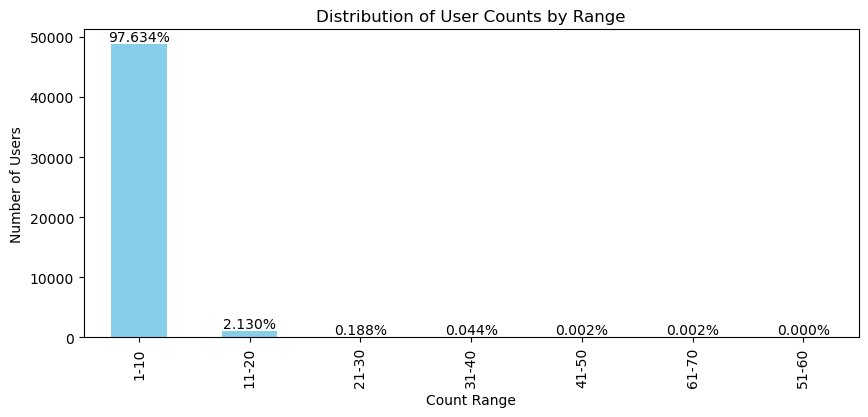

In [29]:
import matplotlib.pyplot as plt
# 创建直方图
plt.figure(figsize=(10, 4))  # 设置图形大小
bars = count_range_counts.plot(kind='bar', color='skyblue')  # 绘制条形图

# 添加标题和轴标签
plt.title('Distribution of User Counts by Range')  # 设置标题
plt.xlabel('Count Range')  # 设置x轴标签
plt.ylabel('Number of Users')  # 设置y轴标签

# 计算总用户数
total_users = count_range_counts.sum()

# 在每个条形上添加百分比
for bar in bars.patches:
    # 计算百分比
    percentage = (bar.get_height() / total_users) * 100
    # 在条形图上添加文本
    plt.text(bar.get_x() + bar.get_width() / 2,  # x位置，位于条形中心
             bar.get_height(),  # y位置，位于条形顶部
             f'{percentage:.3f}%',  # 文本内容，百分比格式
             ha='center',  # 水平对齐方式
             va='bottom',  # 垂直对齐方式
             color='black',  # 文本颜色
             fontsize=10)  # 字体大小

# 显示图形
plt.show()

先筛选出交互大于20的用户，再筛选时间间隔,间隔小,一共只有6天，该数据集，应该不符合长中短期兴趣

In [30]:
# 将bf和uc按照user_id进行左连接
merged_df = pd.merge(bf, uc, on='user_id', how='left')

# 使用query方法筛选出count大于等于20的行
trimmed_bf = merged_df.query('count >= 20')

In [31]:
trimmed_bf.head()

,user_id,time,history,impressions,choose,count,count_range
465,287,2019-11-12 06:04:22,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N33619-1 N49180-0,N33619,20,11-20
466,287,2019-11-14 08:06:16,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N23446-0 N38779-1,N38779,20,11-20
467,287,2019-11-09 15:08:20,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N8929-0 N43595-0 N5442-0 N60374-0 N27845-0 N18...,N18870,20,11-20
468,287,2019-11-10 23:24:46,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N27486-0 N63646-0 N50060-1 N28047-0 N27581-0 N...,N50060,20,11-20
469,287,2019-11-14 07:26:00,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N48017-0 N47098-1 N49712-0 N50872-0 N51570-0 N...,N47098,20,11-20


把impressions中的-0-1去掉

In [32]:
trimmed_bf.loc[:, 'impressions'] = trimmed_bf['impressions'].apply(lambda x: ' '.join([item.split('-')[0] for item in x.split(' ')]))

trimmed_bf.head()

,user_id,time,history,impressions,choose,count,count_range
465,287,2019-11-12 06:04:22,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N33619 N49180,N33619,20,11-20
466,287,2019-11-14 08:06:16,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N23446 N38779,N38779,20,11-20
467,287,2019-11-09 15:08:20,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N8929 N43595 N5442 N60374 N27845 N18870 N3930 ...,N18870,20,11-20
468,287,2019-11-10 23:24:46,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N27486 N63646 N50060 N28047 N27581 N31273 N430...,N50060,20,11-20
469,287,2019-11-14 07:26:00,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N48017 N47098 N49712 N50872 N51570 N46821 N234...,N47098,20,11-20


In [33]:
feature_names = ['user_id', 'time', 'choose', 'impressions', 'history']
trimmed_bf = trimmed_bf[feature_names]
trimmed_bf.head()

,user_id,time,choose,impressions,history
465,287,2019-11-12 06:04:22,N33619,N33619 N49180,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
466,287,2019-11-14 08:06:16,N38779,N23446 N38779,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
467,287,2019-11-09 15:08:20,N18870,N8929 N43595 N5442 N60374 N27845 N18870 N3930 ...,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
468,287,2019-11-10 23:24:46,N50060,N27486 N63646 N50060 N28047 N27581 N31273 N430...,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
469,287,2019-11-14 07:26:00,N47098,N48017 N47098 N49712 N50872 N51570 N46821 N234...,N6466 N53954 N51163 N26618 N55743 N44796 N5670...


In [34]:
trimmed_bf = trimmed_bf.reset_index(drop=True)
trimmed_bf.head()

,user_id,time,choose,impressions,history
0,287,2019-11-12 06:04:22,N33619,N33619 N49180,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
1,287,2019-11-14 08:06:16,N38779,N23446 N38779,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
2,287,2019-11-09 15:08:20,N18870,N8929 N43595 N5442 N60374 N27845 N18870 N3930 ...,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
3,287,2019-11-10 23:24:46,N50060,N27486 N63646 N50060 N28047 N27581 N31273 N430...,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
4,287,2019-11-14 07:26:00,N47098,N48017 N47098 N49712 N50872 N51570 N46821 N234...,N6466 N53954 N51163 N26618 N55743 N44796 N5670...


计算用户的中期兴趣

形似定义？什么样的相似度属于中期兴趣，什么样的相似度属于短期兴趣。因为没有topic，什么样的实体属于topic，实体和topic维度差距较大
只能通过比较，但是相似度没法区分“探索兴趣”

为何不直接搜索到用户最后一天的交互，history就是历史兴趣，impressions就是系统推荐流量(展示量)
若有时间，可以试试收集refuse，即负反馈，但是负反馈不能代表负面兴趣，它不是隐式反馈
拿“活跃用户”进行试验看看，长期兴趣的相似度
思路：每一行计算一个组相似度：
* interest: history_avg_embedding作为**用户兴趣（当前时间）**。
* item_diversity: impressions成对距离作为**多样性（项目间）**（不同用户兴趣本身就不同，可能没有参考价值），相似度和多样性负相关。
* rec_diversity: 用户兴趣和impressions的平均距离作为**推荐多样性**（最后归一化处理），距离和多样性负相关，和准确度正相关。
* faithful/belief: choose和interest的距离作为用户忠于现有兴趣（固有兴趣？）的程度，一定程度上反应陷入过滤气泡的深浅。(忠诚，信念)用户信念？

In [34]:
# 应用于数据列的apply函数
# 定义一个函数，计算history对应的平均嵌入距离
def history_avg_embedding(history):
    # 将history拆分为物品ID列表
    items = history.split()
    interest = np.mean()
    # 返回被选取的物品ID列表
    return ', '.join(chosen_items)

In [38]:
ne["average_embedding"][1]

'[-0.013597 -0.009758  0.01712  -0.051993  0.037963  0.045238  0.077176\n -0.033402  0.032126  0.000231 -0.041168  0.006686 -0.042137  0.003012\n -0.007492  0.004021 -0.044446  0.060362  0.036527  0.000915 -0.0881\n  0.013638  0.00664   0.023534 -0.006483 -0.030089 -0.01769  -0.076201\n  0.010523 -0.015482 -0.029464 -0.000577  0.011122  0.020931  0.019831\n -0.020024  0.046285 -0.087435 -0.014035 -0.032755  0.000882  0.058146\n -0.063754 -0.01612  -0.028519 -0.006055  0.043857  0.012439  0.008123\n  0.068035 -0.025732 -0.082524  0.012157  0.005102  0.050669 -0.029057\n -0.097563  0.01637   0.104147 -0.013962 -0.085338  0.002964  0.002371\n  0.033141 -0.094885 -0.041572 -0.083391 -0.017752 -0.021868  0.003052\n  0.065026  0.018371 -0.009355  0.078348  0.028948 -0.043366  0.007608\n  0.031137  0.054513  0.030671 -0.021131 -0.048048 -0.013872 -0.000741\n -0.059595 -0.109701  0.046302  0.016114  0.05821  -0.015325 -0.085929\n -0.059981  0.004588 -0.028985 -0.059973 -0.035562  0.106053 -0.1